In [1]:
import Pkg; 
Pkg.add("Plots")
Pkg.add("PyCall")
Pkg.add("LinearAlgebra")
using Plots
using PyCall
using LinearAlgebra

   Updating registry at `C:\Users\sfber\.julia\registries\General`
   Updating git-repo `https://github.com/JuliaRegistries/General.git`


Fetching: [========================================>]  99.9 %0.0 %>                                     ]  7.4 %                                   ]  10.6 %                                  ]  14.0 % [========>                                ]  18.8 %]  22.7 % [============>                            ]  28.0 %                           ]  31.7 %Fetching: [===============>                         ]  36.1 % [=================>                       ]  41.8 %===================>                     ]  45.7 %.9 % [======================>                  ]  54.0 % [==========================>              ]  62.9 %.8 %71.2 %74.9 %.4 % [===================================>     ]  85.2 % [====================================>    ]  88.6 %======================================>  ]  92.8 %=======================================> ]  97.4 %

  Resolving package versions...
   Updating `C:\Users\sfber\.julia\environments\v1.4\Project.toml`
 [no changes]
   Updating `C:\Users\sfber\.julia\environments\v1.4\Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `C:\Users\sfber\.julia\environments\v1.4\Project.toml`
 [no changes]
   Updating `C:\Users\sfber\.julia\environments\v1.4\Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `C:\Users\sfber\.julia\environments\v1.4\Project.toml`
 [no changes]
   Updating `C:\Users\sfber\.julia\environments\v1.4\Manifest.toml`
 [no changes]


Le but de ce TP est, dans un premier temps, d'étudier numériquement la méthode des éléments finis pour approcher la solution de l'équation de la chaleur. Dans un second temps, on va s'intéresser à un autre type d'approximation de Galerkin, appelée méthode Proper Orthogonal Decomposition (POD), qui est basée sur la décomposition en composantes principales que vous avez étudiée dans le DM préparatoire.

Le but de la première partie du TP est d'implémenter la méthode des éléments finis. Dans la deuxième partie, nous allons étudier l'évolution de l'erreur commise par la méthode des élements finis en fonction de la discrétisation en temps. La troisième partie est consacrée à l'erreur de discrétisation en espace. Enfin, la quatrième partie sera consacrée à l'étude et l'implémentation de la méthode POD.

Remarques générales sur le déroulement du TP: 

*Ecrire vos réponses dans les cellules de texte commençant par REPONSE.
Vous pouvez taper des formules en écrivant du code Latex usuel.

*A plusieurs reprises, on vous demande d'indiquer les abscisses, les ordonnées et les labels des courbes affichées.

*Rendre le fichier .ipynb en l'envoyant à l'adresse e-mail virginie.ehrlacher@enpc.fr pour le 26 mai 2020.

Tout au long de ce TP, nous considèrerons la solution $u(t,x)$ de l'équation de la chaleur sur le domaine $\Omega = (0,1)$ avec un terme source $f\in L^2(]0,T[, L^2(0,1))$ et une condition initiale $g\in L^2(0,1)$. Le temps final est noté $T>0$.

Nous allons choisir ici un terme source $f(t,x)$ de la forme
$$
f(t,x) = r(t) s(x),
$$
avec 
$$
r(t) = 10 \cos(4\pi t)
$$
et 
$$
s(x) = 0.5 - |x-0.5|.
$$
Le temps final est donné par $T=0.5$ et la condition initiale est $g = 0$.

In [2]:
#Temps final
T = 0.5;

In [3]:
#Fonction qui renvoie la valeur du terme source f(t,x). 
function r(t)
    return 10*cos(4*pi*t)
end

function s(x)
    return (0.5- abs(x-0.5))
end

function f(t,x) 
    return r(t)*s(x)
end

f (generic function with 1 method)

In [4]:
#Fonction qui renvoie la valeur de la condition initiale g(x)
function g(x)
    return 0
end

g (generic function with 1 method)

# I- Implémentation de la méthode des éléments finis

Dans cette première partie, nous commençons par mettre en oeuvre la méthode des éléments finis $\mathbb{P}_1$ associée à une grille de dsicrétisation uniforme de l'intervalle $(0,1)$ que nous avons vue dans le cours. 

Nous commençons par définir les matrices intervenant dans la discrétisation en espace.

Pour un entier $N_h \in \mathbb{N}^*$, on notera 
$$
\Delta x  = \frac{1}{N_h +1}, \quad x_i = i \Delta x, \quad \forall 0\leq i \leq N_h +1,
$$
$$
\forall 1\leq i \leq N_h, \quad \phi^h_i(x) = \left\{
\begin{array}{ll}
1 - \frac{|x-x_i|}{\Delta x} & \mbox{ si } x\in [x_{i-1}, x_{i+1}],\\
0 & \mbox{sinon.}\\
\end{array}
\right.
$$
On notera également
$$
V_h:= {\rm Vect}\left\{ \phi_1^h, \cdots, \phi_{N_h}^h\right\}
$$
Notez que ${\rm dim}(V_h) = N_h$.

Les matrices $S_h:=\left( S_{h,ij}\right)_{1\leq i,j \leq N_h}$ et $K_h:= \left( K_{h,ij}\right)_{1\leq i,j \leq N_h}$ sont définies telles que pour tout $1\leq i, j \leq N_h$, 
$$
S_{h,ij} = \langle \phi^h_i, \phi^h_j \rangle_{L^2(0,1)} \quad K_{h,ij} = \int_{(0,1)}\frac{d}{dx}\phi^h_i(x)\frac{d}{dx}\phi_j^h(x)\,dx.
$$

1) Vérifier que pour tout $1\leq i\neq j\leq N_h$, 
$$
S_{h,ii} = \frac{2}{3}\Delta x, \quad S_{h,ij} = \frac{1}{6}\Delta x \mbox{ si }j=i+1 \mbox{ ou }j=i-1, \quad S_{h,ij} = 0 \mbox{ sinon}
$$
et 
$$
K_{h,ii} = \frac{2}{\Delta x}, \quad K_{h,ij} = - \frac{1}{\Delta x} \mbox{ si }j=i+1 \mbox{ ou }j=i-1, \quad K_{h,ij} = 0 \mbox{ sinon}.
$$

REPONSE: 

\begin{align*}
S_{h,ii}
&=\int_{x_{i-1}}^{x_{i+1}}(1-\frac{|x-x_i|}{\Delta x})^2\ dx\\
&=\int_{x_{i-1}}^{x_{i+1}}(\frac{(x-x_i)^2}{\Delta x^2}-2\frac{|x-x_i|}{\Delta x}+1)\ dx\\
&=\frac{(x-x_i)^3}{3\Delta x^2}\bigg|_{x_{i-1}}^{x_{i+1}}+\bigg|_{x_{i-1}}^{x_{i}}-\bigg|_{x_{i}}^{x_{i+1}}+x\bigg|_{x_{i-1}}^{x_{i+1}}\\
&=\frac{2\delta x}{3}-\Delta x-\Delta x+2\Delta x=\frac{2\Delta x}{3}
\end{align*} 
Si $j=i+1$
\begin{align*}
S_{h,ij}
&=\int_{x_{i-1}}^{x_i}\phi_{i}^h\phi_{i+1}^h\ dx+\int_{x_{i}}^{x_{i+1}}\phi_{i}^h\phi_{i+1}^h\ dx+\int_{x_{i+1}}^{x_{i+2}}\phi_{i}^h\phi_{i+1}^h\ dx\\
&=0+\int_{x_{i}}^{x_{i+1}}\phi_{i}^h\phi_{i+1}^h\ dx+0\\
&=\int_{x_{i}}^{x_{i+1}}(1-\frac{x-x_i}{\Delta x})(1-\frac{x_{i+1}-x}{\Delta x})\ dx\\
&=\int_{x_{i}}^{x_{i+1}}1-\frac{x-x_i+x_{i+1}-x}{\Delta x}+\frac{(x-x_i)(x_{i+1}-x)}{\Delta x^2}\ dx\\
&=\int_{x_{i}}^{x_{i+1}}\frac{(x-x_i)(x_{i+1}-x)}{\Delta x^2}\ dx\\
&=-\frac{x_{i}x_{i+1}}{\Delta x}+\frac{x_{i+1}+x_{i}}{2\Delta x^2}(x_{i+1}^2-x_{i}^2)-\frac{1}{3\delta x^3}[x_{i+1}^3-x_{i}^3]\\
&=-\frac{x_ix_{i+1}}{\Delta x}+\frac{(x_{i+1}+x_{i})^2}{2\Delta x}-\frac{x_{i+1}^2+x_{i+1}x_{i}+x_{i}^2}{3\Delta x}\\
&=\frac{(x_{i+1}-x_{i})^2}{6\Delta x}=\frac{\Delta x}{6}
\end{align*}
Le cas $j=i-1$ est pareil.
\begin{align*}
K_{h,ii}
&=\int_{x_{i-1}}^{x_{i}}\frac{1}{\Delta x}\frac{1}{\Delta x}\ dx+\int_{x_{i}}^{x_{i+1}}(-\frac{1}{\Delta x})(-\frac{1}{\Delta x})\\
&=\frac{x_{i}-x_{i-1}}{\Delta x^2}+\frac{x_{i+1}-x_{i}}{\Delta x^2}\\
&=\frac{2}{\Delta x}
\end{align*}
Si $j=i+1$
\begin{align*}
K_{h,ij}
&=\int_{x_{i-1}}^{x_i}\frac{1}{\Delta x}\cdot 0\ dx+\int_{x_i}^{x_{i+1}}\frac{1}{\Delta x}\frac{-1}{\Delta x}\ dx+\int_{x_{i+1}}^{x_{i+2}}0\cdot\frac{-1}{\Delta x}\\
&=\int_{x_i}^{x_{i+1}}\frac{1}{\Delta x}\frac{-1}{\Delta x}\ dx\\
&=\frac{-1}{\Delta x}(x_{i+1}-x_{i})\\
&=-\frac{1}{\Delta x}
\end{align*}
Le cas $j=i-1$ est pareil.

In [5]:
#Définition du pas de temps Deltax en fonction de Nh
function Deltax(Nh)
    return 1.0/(Nh+1)
end

Deltax (generic function with 1 method)

In [6]:
#Définition de la grille de discrétisation
function xgrid(Nh)
    xvec = zeros(Nh)
    for i in 1:Nh
        xvec[i]= i*Deltax(Nh)
    end
    return xvec
end

xgrid (generic function with 1 method)

In [7]:
# Définition de la matrice Sh en fonction de Nh
function Sh(Nh)
    Sh = zeros((Nh, Nh))
    dx = Deltax(Nh)
    for i in 1:Nh
        Sh[i,i] = 2.0/3.0*dx
        if (i>1)
            Sh[i-1,i] = 1.0/6.0*dx
        end
        if (i<Nh)
            Sh[i+1,i] = 1.0/6.0*dx
        end
    end
    return Sh
end

Sh (generic function with 1 method)

In [8]:
#Définition de la matrice Kh en fonction de Nh
function Kh(Nh)
    Kh = zeros((Nh, Nh))
    dx = Deltax(Nh)
    for i in 1:Nh
        Kh[i,i] = 2.0/dx
        if (i>1)
            Kh[i-1,i] = -1.0/dx
        end
        if (i<Nh)
            Kh[i+1,i] = -1.0/dx
        end
    end
    return Kh
end

Kh (generic function with 1 method)

Nous définissons ensuite le vecteur $U_h^0\in \mathbb{R}^{N_h}$ correspondant à la condition initiale. Celui-ci est la solution du problème 
$S_h U_h^0  = G_h$ où $G_h:= \left(\langle g, \phi_i^h \rangle_{L^2(0,1)}\right)_{1\leq i \leq N_h}$ 

2) Montrer que $U_h^0 = 0$.

REPONSE:

Car la condition initiale est $g=0$, le produit interne $\langle g,\phi_i^h\rangle_{L^2(0,1)}=0$ pour tout entier $1\leq i\leq N_h$.
le Matrice $G_h=\lbrack 0\rbrack_{N_h\times N_h}$. Donc $U_h^0={S_h}^{-1}G_h=0$

In [9]:
#Définition de la condition initiale U_h(0) en fonction de Nh
function U0h(Nh)
    return zeros(Nh)
end

U0h (generic function with 1 method)

Le but des lignes de code ci-dessous est d'afficher la condition initiale.

In [9]:
function plot_condition_initiale(Nh)
    print("Affichage de la fonction U0 initiale pour Nh = 10")  
    plot(xgrid(Nh), U0h(Nh),title = "Initial condition", label = "u_0", xlabel = "x", ylabel = "u_0(x)", ylims = (-0.1, 0.1) ) 
end

plot_condition_initiale (generic function with 1 method)

Affichage de la fonction U0 initiale pour Nh = 10

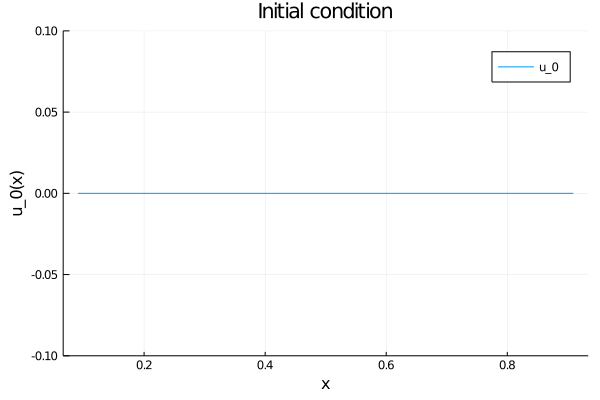

In [25]:
plot_condition_initiale(10)

Les lignes de code suivantes permettent de renvoyer la valeur du vecteur $F_h(t) = (F_{h,i}(t))_{1\leq i \leq N_h}$ où
$$
F_{h,i}(t) = \langle f(t), \phi^h_i\rangle_{L^2(0,1)}.
$$
3) Montrer que comme $f(t,x) = r(t) s(x)$, on a alors 
$$
F_h(t) = r(t) \overline{F}_h
$$
pour un vecteur $\overline{F}_h = (\overline{F}_{h,i})_{1\leq i \leq N_h}$ dont on donnera l'expression en fonction de $s$ et de $\phi_i^h$ pour $1\leq i \leq N_h$.

REPONSE: 

Pour tout entier $1\leq i\leq N_h$,
\begin{align*}
F_{h,i}(t) 
&= \langle f(t), \phi^h_i\rangle_{L^2(0,1)}\\
&= \langle r(t)s(x), \phi^h_i\rangle_{L^2(0,1)}\\
&= r(t)\langle s(x),\phi^h_i\rangle_{L^2(0,1)}\\
\end{align*}
Donc $F_h(t) = r(t) \overline{F}_h$, d'où
$$
\overline{F}_h = (\overline{F}_{h,i})_{1\leq i \leq N_h}\\
\overline{F}_{h,i}=\langle s(x),\phi^h_i\rangle_{L^2(0,1)}
$$

In [10]:
#Fonction qui renvoie la valeur du vecteur Fh(t)
function Fbarh(Nh) 
    Fh= zeros(Nh)
    for i in 1:Nh 
        Fh[i] = s(xgrid(Nh)[i])
    end
        
    Gh = Sh(Nh)*Fh
    return Gh
end
    

function Fh(t,Nh)
    return r(t)*Fbarh(Nh)
end

Fh (generic function with 1 method)

Nous introduisons ensuite les différents paramètres de discrétisation en temps, en particulier le pas de temps 
$$
\Delta t = T/P
$$
avec $P\in \mathbb{N}^*$ un entier.

In [11]:
#Fonction qui renvoie la valeur du pas de temps Deltat en fonction de l'entier P
function Deltat(P)
    return T/P
end

Deltat (generic function with 1 method)

Le but des lignes de code suivantes est de montrer une animation illustrant l'évolution du terme source $f(t,x)$ au cours du temps. Faire tourner le code pour visualiser l'évolution de $f$.

┌ Info: Saved animation to 
│   fn = E:\codeJUPYTER\Julia Scripts\TD_POD\anim_f.gif
└ @ Plots C:\Users\sfber\.julia\packages\Plots\kgqnU\src\animation.jl:102


Plots.AnimatedGif("E:\\codeJUPYTER\\Julia Scripts\\TD_POD\\anim_f.gif")
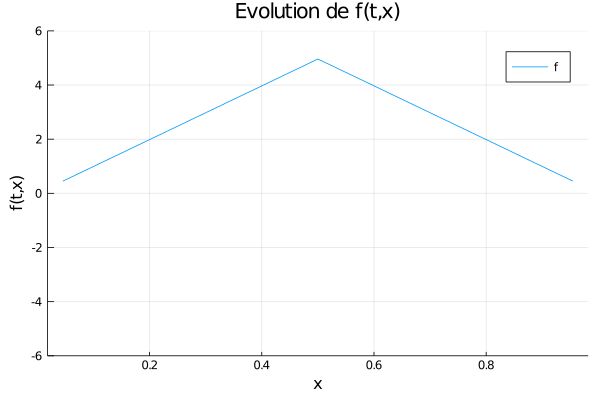

In [28]:
## Le but de cette fonction est d'afficher l'évolution de f(t,x) au cours du temps
Nhplot = 21
Pplot = 50
Fplot = zeros((Nhplot,Pplot+1))

xplot = xgrid(Nhplot)
dtplot = Deltat(Pplot)
for p in 1:(Pplot+1)
    for i in 1:Nhplot
        Fplot[i,p]= f(p*dtplot, xplot[i])
    end
end

anim = @animate for p in 1:(Pplot+1)
    plot(xplot, Fplot[:,p], ylims = (-6, 6), title = "Evolution de f(t,x)", label = "f", xlabel = "x", ylabel = "f(t,x)")
end
gif(anim, "anim_f.gif", fps = 15)

In [29]:
closeall()

Nous définissons ensuite une fonction qui permet de résoudre l'équation de la chaleur, avec une discrétisation en espace caractérisée par un entier $N_h$, une discrétisation en temps caractérisée par un entier $P$, et à l'aide d'un $\theta$-schéma caractérisé par un réel $\theta\in [0,1]$.

4) Remplir les lignes de code correspondantes pour implémenter un theta-schéma pour résoudre l'équation de la chaleur pour un pas de temps $\Delta t = \frac{T}{P}$ et un pas d'espace d'espace $\Delta x = \frac{1}{N_h +1}$. 
Les solutions aux différents pas de temps sont stockées dans une matrice $W\in \mathbb{R}^{N_h \times (P+1)}$ telle que $W_{i,p}  = U_{h,i}^p$

In [12]:
# Résolution de l'équation de la chaleur par la méthode des éléments avec un theta-schéma
function sol_chaleur(Nh, P, theta)
    dt = Deltat(P)
    S = Sh(Nh)
    K = Kh(Nh)
    t = 0

    W = zeros((Nh,P+1));
    Uold = U0h(Nh)
    W[1:Nh,1] = Uold;
    
    ## Uold représente U^p
    ## Unew représente U^{p+1}
    for p in 0:(P-1)
        
        t +=dt
        ## println(t)
        B = (S-(1-theta)*dt*K)*Uold+dt*(theta*Fh(t,Nh)+(1-theta)*Fh(t-dt,Nh));## TO COMPLETE
        A = (S+theta*dt*K);## TO COMPLETE
 
        Unew = A\B ## Calcul la solution du problème A^{-1}B
        W[:,p+2] = Unew 
        Uold = Unew
    end
        
    return W
end

sol_chaleur (generic function with 1 method)

Nous allons maintenant tester cette fonction avec des valeurs tests, à savoir $N_{h,try} = 50$, $P_{try}= 500$ et 
$\theta_{try}= 1$ (ce qui correspond à un schéma d'Euler implicite). Le code peut prendre quelques secondes à tourner.

In [31]:
Ptry = 50
Nhtry = 21
thetatry = 1

Wtry = sol_chaleur(Nhtry, Ptry,thetatry);

Les lignes de code suivantes permettent de voir l'évolution de la solution obtenue. 

┌ Info: Saved animation to 
│   fn = E:\codeJUPYTER\Julia Scripts\TD_POD\anim_u.gif
└ @ Plots C:\Users\sfber\.julia\packages\Plots\kgqnU\src\animation.jl:102


Plots.AnimatedGif("E:\\codeJUPYTER\\Julia Scripts\\TD_POD\\anim_u.gif")
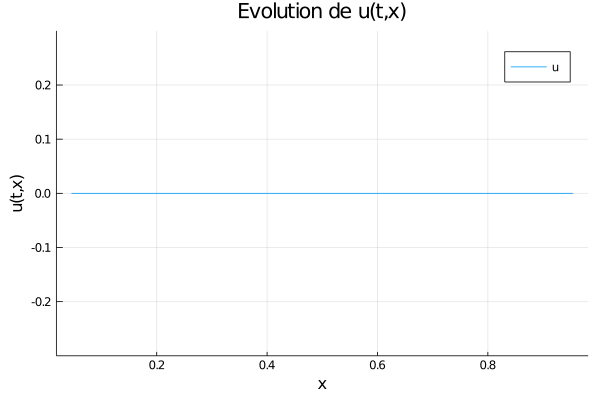

In [32]:
anim2 = @animate for p in 1:(Ptry+1)
    plot(xplot, Wtry[:,p], ylims = (-0.3, 0.3), title = "Evolution de u(t,x)", label = "u", xlabel = "x", ylabel = "u(t,x)")
end
gif(anim2, "anim_u.gif", fps = 15)

In [33]:
closeall()

5) Qu'observez-vous quant à la régularité de la solution $u$ en $x$ (en comparaison de la régularité du terme source $f$ en $x$)?  

REPONSE: Le courbe de la solution u(x) est plus lissé et en respectant la même symétrie par rapport au x=0.5.  

# II- Etude de l'évolution de l'erreur en fonction de la discrétisation en temps

Le but de cette partie est d'étudier l'influence du pas de temps $\Delta t$ sur l'erreur d'approximation donnée par ce schéma, pour une valeur de discrétisation en espace $N_h$ fixée.

In [34]:
#Valeur de Nh fixée dans cette partie
Nh = 31

31

Nous allons tout d'abord étudier la stabilité du schéma en temps, en fonction de la valeur de $\theta$ et du pas de temps $\Delta t$. Les lignes de code ci-dessous permettent de calculer la solution de l'équation de la chaleur pour différentes valeurs de $P$ (i.e. de $\Delta t$) et de $\theta$. 

1) Faites tourner les lignes de code contenues dans les deux cellules ci-dessous pour calculer et visualiser l'évolution de la solution approchée pour les valeurs de $\theta = 1$ (schéma implicite) puis $0.5$ (schéma de Cranck-Nicholson) puis $0$ (schéma explicite). Que constatez-vous?

REPONSE:
Pour le schéma explicite, l'itération diverge. Pour le schéma implicite et le schéma explicite,l'itération converge.C'est bon.Je vois aucune différence entre les deux cas. 

In [43]:
# Paramètres de discrétisation en temps
P = 500
theta = 0.0

W = sol_chaleur(Nh, P,theta);

┌ Info: Saved animation to 
│   fn = E:\codeJUPYTER\Julia Scripts\TD_POD\anim_u_scheme1.gif
└ @ Plots C:\Users\sfber\.julia\packages\Plots\kgqnU\src\animation.jl:102


Plots.AnimatedGif("E:\\codeJUPYTER\\Julia Scripts\\TD_POD\\anim_u_scheme1.gif")
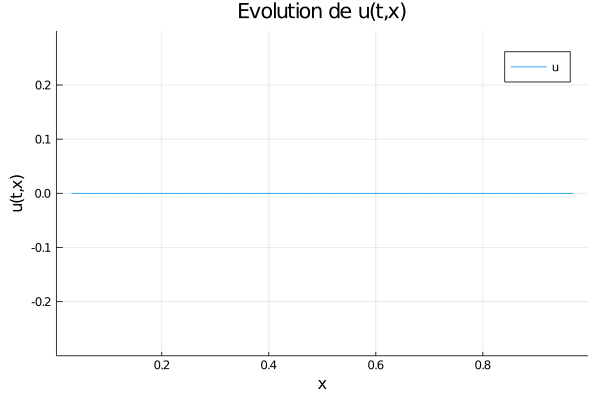

In [36]:
anim3 = @animate for p in 1:(P+1)
    plot(xgrid(Nh), W[:,p], ylims = (-0.3, 0.3), title = "Evolution de u(t,x)", label = "u", xlabel = "x", ylabel = "u(t,x)")
end
gif(anim3, "anim_u_scheme1.gif", fps = 15)

In [44]:
closeall()

Nous allons maintenant calculer les valeurs propres de la matrice $C := S_h^{-1/2} K_h S_h^{-1/2}$. 

2) Remplir les lignes de code correspondantes dans la cellule ci-dessous. Quelle est la valeur de la plus grande valeur propre de cette matrice? 

REPONSE: 12199.670214084126

In [45]:
S = Sh(Nh)
K = Kh(Nh)

#On calcule tout d'abord la racine carrée de la matrice Sh, puis son inverse
Racine = sqrt(S)
invRacine = inv(Racine)

C = invRacine*K*invRacine## TO COMPLETE

#print(C)
vals = eigvals(C)
#vecs = eigvecs(C)
print(vals)

## [9.877534117533502, 39.60541471359624, 89.47038060400952, 159.95329049995652, 251.7333699634401, 365.6937363954745, 502.92770185850907, 664.745088334159, 852.6774174539015, 1068.48031529197, 1314.1307506588873, 1591.81574019848, 1903.9078356738798, 2252.92099005326, 2641.438233886243, 3072.0000000000095, 3546.9390672394156, 4068.1453637441746, 4636.7421240169215, 5252.655651004753, 5914.066631185698, 6616.74505064541, 7353.297418247896, 8112.3977688087225, 8878.13287025588, 9629.659114094198, 10341.422191002826, 10984.193874997836, 11527.088847001787, 11940.511188468936, 12199.670214084126]


[9.877534117533502, 39.60541471359624, 89.47038060400952, 159.95329049995652, 251.7333699634401, 365.6937363954745, 502.92770185850907, 664.745088334159, 852.6774174539015, 1068.48031529197, 1314.1307506588873, 1591.81574019848, 1903.9078356738798, 2252.92099005326, 2641.438233886243, 3072.0000000000095, 3546.9390672394156, 4068.1453637441746, 4636.7421240169215, 5252.655651004753, 5914.066631185698, 6616.74505064541, 7353.297418247896, 8112.3977688087225, 8878.13287025588, 9629.659114094198, 10341.422191002826, 10984.193874997836, 11527.088847001787, 11940.511188468936, 12199.670214084126]

3) En déduire la valeur de $P$ la plus petite possible pour que le schéma d'Euler explicite soit stable.  

REPONSE: Pour ce schéma-là, selon le lemme dans notre slides, si theta prends 0, il faut augmenter le nombre de pas jusqu'à l'infini. On exprime la valeur de P en fonction de $\theta$ ci-dessous: $P>=T*\lambda_{max}\frac{1-2\theta}{2}$. Actuellement le $T=0.5$,donc quand $\theta=0$,$P_{min} = \frac{0.5*12199.670214084126}{2}=3050$ 

4) Faire maintenant varier la valeur de $N_h$ ci-dessus et observez comment la plus grande valeur propre de la matrice $S_h^{-1/2}K_h S_h^{-1/2}$ évolue en fonction de $N_h$. Que constatez-vous?

In [46]:
function calvalpropreC(Nh)
    j=0;
    Valmax = zeros(length(Nh),1);
    for i in Nh
        j += 1;
        S = Sh(i);
        K = Kh(i);
        #On calcule tout d'abord la racine carrée de la matrice Sh, puis son inverse
        Racine = sqrt(S);
        invRacine = inv(Racine);
        C = invRacine*K*invRacine## TO COMPLETE
        println(maximum(eigvals(C)));
        Valmax[j] = maximum(eigvals(C));
    end
    return Valmax
end
Nh = [31,61,121,241,481];
calvalpropreC(Nh);
using StatsPlots
plot(Nh,Valmax);

12199.670214084126
46039.30640177667
178519.20790615815
702679.1822918319
2.7877991757615646e6


ArgumentError: ArgumentError: Package StatsPlots not found in current path:
- Run `import Pkg; Pkg.add("StatsPlots")` to install the StatsPlots package.


REPONSE: 
la plus grande valeur propre de la matrice $C$ augemente par rapport à la variable $Nh$. 

Dans la suite du TP, nous allons étudier comment l'erreur d'approximation évolue en fonction du pas de temps $\Delta t$ pour une valeur de discrétisation spatiale fixée pour le schéma d'Euler implicite et le schéma de Cranck-Nicholson. Pour ce faire, nous allons fixer la valeur de $N_h$.

In [47]:
#Valeur de Nh fixée dans cette partie 
Nh = 31

31

Pour calculer ces erreurs, nous avons besoin de calculer une solution de référence. Comme on ne dispose pas de la solution exacte, la solution de référence est ici la solution numérique calculée pour une valeur $P_{ref}$ très grande. On supposera que celle-ci fournit une approximation suffisamment précise de la solution exacte. Ensuite, nous calculerons les erreurs entre cette solution numérique de référence et la solution obtenue pour des valeurs de $P$ beaucoup plus petites que $P_{ref}$. 

Nous commençons par fixer une très grande valeur $P_{ref}$ de référence et nous calculons la solution de référence associée avec un schéma de Cranck-Nicholson. Nous allons supposer que cette solution est suffisamment proche de la solution exacte de l'équation de la chaleur pour pouvoir la comparer à d'autres solutions. Ce calcul peut prendre quelques minutes. On notera également
$$
\Delta t_{ref}:= \frac{T}{P_{ref}}.
$$

In [48]:
Pref = 2048
Wref = sol_chaleur(Nh,Pref,0.5);

Nous allons comparer cette solution de référence avec des solutions obtenues pour des valeurs de $P$ telles que 
$$
P_{ref} = m P.
$$
avec $m\in \mathbb{N}^*$.  

Dans toute la suite, nous noterons, pour tout $P\in \mathbb{N}^*$, et pour tout $0\leq p \leq P$, 
$$
u_{h,P}^p:= \sum_{i=1}^{N_h} U_{h,P,i}^p \phi_i^h,
$$
où $\left( U_{h,P}^p\right)_{0\leq p \leq P}$ est la solution donnée par le schéma numérique considéré pour un pas de temps $\Delta t = \frac{T}{P}$ et où pour tout $0\leq p\leq P$, $U_{h,P}^p:= \left( U_{h,P,i}^p\right)_{1\leq i \leq N_h}$. La fonction $u_{h,P}^p$ est donc une approximation après discrétisation en temps de la solution $u_h(t^P_p)$ où $[0,T] \ni t \mapsto u_h(t)$ est la solution en temps continu de l'approximation de Galerkin de l'équation de la chaleur obtenue avec l'espace de discrétisation $V_h$, et où $t^P_p := p\Delta t= p\frac{T}{P}$.  

5) Montrer que pour tout $1\leq p \leq P$, on a 
$$
t^P_p = mp \Delta t_{ref} = t^{P_{ref}}_{mp}.
$$

REPONSE:

 $t^P_p = p\frac{T}{P} = mp\frac{T}{mP} = mp\frac{T}{P^{ref}} = mp\Delta t_{ref} = t^{P_{ref}}_{mp}$

Nous allons calculer l'erreur
$$
\max_{0\leq p \leq P} \| u_{h,P}^p - u_{h,P_{ref}}^{mp}\|_{L^2(0,1)}.
$$
Notez que $u_{h,P}^p$ et $u_{h,P_{ref}}^{mp}$, d'après les questions précédentes, sont deux approximations de $u_h(t_p^P)$.

6) Montrer que 
$$
\|u_{h,P}^p - u_{h,P_{ref}}^{mp}\|_{L^2(0,1)}^2 = (U_{h,P}^p - U_{h, P_{ref}}^{mp})^T S_h (U_{h,P}^p - U_{h, P_{ref}}^{mp}).
$$

REPONSE:
$$
\begin{align*}
\|u_{h,P}^p - u_{h,P_{ref}}^{mp}\|_{L^2(0,1)}^2&= \|\sum_{i=1}^{N_h}(U_{h,P,i}^p-U_{h,P_{ref},i}^{mp})\phi_i^h\|_{L^2(0,1)}^2\\
                                &= \int_{x\in[0,1]}\lbrack\sum_{i=1}^{N_h}(U_{h,P,i}^p-U_{h,P_{ref},i}^{mp})\phi_i^h\rbrack^2\\
                                &= \int_{x\in[0,1]}\lbrack\sum_{i=1}^{N_h}(U_{h,P,i}^p-U_{h,P_{ref},i}^{mp})\phi_i^h\rbrack \lbrack\sum_{j=1}^{N_h}(U_{h,P,j}^p-U_{h,P_{ref},j}^{mp})\phi_j^h\rbrack\\ 
                                &= \sum_{i=1}^{N_h}\sum_{j=1}^{N_h}\lbrack(U_{h,P,i}^p-U_{h,P_{ref},i}^{mp})(U_{h,P,j}^p-U_{h,P_{ref},j}^{mp})\int_{x\in[0,1]}\phi_i^h\phi_j^h\rbrack\\
                                &= \sum_{i=1}^{N_h}\sum_{j=1}^{N_h}\lbrack(U_{h,P,i}^p-U_{h,P_{ref},i}^{mp})(U_{h,P,j}^p-U_{h,P_{ref},j}^{mp})S_{h,ij}\rbrack\\
                                &= (U_{h,P}^p - U_{h, P_{ref}}^{mp})^T S_h (U_{h,P}^p - U_{h, P_{ref}}^{mp}).
\end{align*}
$$

Remplir les lignes de code ci-dessous pour pouvoir calculer $$
\max_{0\leq p \leq P} \| u_{h,P}^p - u_{h,P_{ref}}^{mp}\|_{L^2(0,1)}
$$ pour un schéma d'Euler implicite et pour un schéma de Cranck-Nicholson. 

In [54]:
#Tableau contenant les différentes valeurs de P pour lesquelles nous allons calculer les erreurs. 
Ptab = [2,4,8,16,32,64,128]

#Tableaux vides qui vont contenir les valeurs des différentes erreurs pour le schéma d'Euler implicite et le schéma de Cranck-Nicholson. 
errtab_imp = []
errtab_CN = []

for P in Ptab
    m = Int(Pref/P);
    W_imp = sol_chaleur(Nh,P,1); ##Contient la solution de l'équation de la chaleur par un schéma implicite avec \Delta t = T/P
    W_CN = sol_chaleur(Nh,P,0.5);  ##Contient la solution de l'équation de la chaleur par un schéma de Cranck-Nicholson avec \Delta t = T/P
    
    err_max_imp = 0;
    for p in 0:P
        time = p*m;
        
        Usol_ref = Wref[:,time+1]; ## contient le vecteur des coordonnées de u_{h, P_{ref}}^{mp}
        Usol_app = W_imp[:,p+1]; ## contient le vecteur des coordonnées de u_{h, P}^{p} avec le schéma implicite
        # print(size(Usol_app))
        # print(size(S))
        
        # err = \| u_{h, P}^{p} -  u_{h, P_{ref}}^{mp} \|_{L^2(0,1)}
        err = (Usol_app-Usol_ref)'*S*(Usol_app-Usol_ref);## TO COMPLETE
        err_max_imp = max(err_max_imp, err);
    end
    
    append!(errtab_imp, err_max_imp )
    
    err_max_CN = 0;
    for p in 0:P
        time = p*m
        
        Usol_ref = Wref[:,time+1]  ## contient le vecteur des coordonnées de u_{h, P_{ref}}^{mp}
        Usol_app= W_CN[:,p+1] ## contient le vecteur des coordonnées de u_{h, P}^{p} avec le schéma de Cranck-Nicholson
        
        # err = \| u_{h, P}^{p} -  u_{h, P_{ref}}^{mp} \|_{L^2(0,1)}
        err = (Usol_app-Usol_ref)'*S*(Usol_app-Usol_ref)## TO COMPLETE
        err_max_CN = max(err_max_CN, err);
    end
    
    append!(errtab_CN, err_max_CN )
end

Les lignes de code ci-dessous permettent de tracer ces erreurs en échelle logarithmique en fonction de $P$ pour les deux types de schémas. 

Compléter ces lignes de code pour afficher les abscisses, les ordonnées et les labels des différentes courbes tracées.  

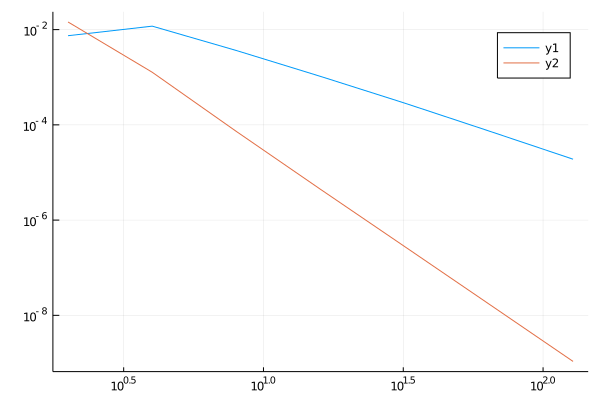

In [55]:
plot(Ptab,[errtab_imp, errtab_CN], xaxis=:log, yaxis=:log)

In [56]:
closeall()

7) Quelles sont les vitesses de convergence de ces erreurs pour ces deux schémas en fonction de $\Delta t$? (Faire une régression linéaire si besoin). 

In [63]:
import Pkg; 
Pkg.add("GLM")
Pkg.add("DataFrames")
using GLM,DataFrames


  Resolving package versions...
  Installed CompilerSupportLibraries_jll ─ v0.3.3+0
  Installed OpenBLAS_jll ───────────────── v0.3.9+4
  Installed FillArrays ─────────────────── v0.8.9
  Installed PDMats ─────────────────────── v0.9.12
  Installed GLM ────────────────────────── v1.3.9
  Installed QuadGK ─────────────────────── v2.3.1
  Installed StatsModels ────────────────── v0.6.11
  Installed SpecialFunctions ───────────── v0.10.2
  Installed DataValueInterfaces ────────── v1.0.0
  Installed Rmath_jll ──────────────────── v0.2.2+0
  Installed ShiftedArrays ──────────────── v1.0.0
  Installed Arpack_jll ─────────────────── v3.5.0+3
  Installed IteratorInterfaceExtensions ── v1.0.0
  Installed Tables ─────────────────────── v1.0.4
  Installed StatsFuns ──────────────────── v0.9.4
  Installed OpenSpecFun_jll ────────────── v0.5.3+3
  Installed Rmath ──────────────────────── v0.6.1
  Installed Distributions ──────────────── v0.23.2
  Installed Arpack ─────────────────────── v0.4.0
  In

ArgumentError: ArgumentError: adding AbstractArray other than AbstractVector as a column of a data frame is not allowed

In [91]:
x=log.(Deltat.(Ptab))
x=-x
print(x)
y=log.(errtab_imp)
y=-y
# print(y)
dataregression = DataFrame(x = x,y = y);
lm(@formula(y ~ x),dataregression)

[1.3862943611198906, 2.0794415416798357, 2.772588722239781, 3.4657359027997265, 4.1588830833596715, 4.852030263919617, 5.545177444479562][4.8991791143226715, 4.43781270499389, 5.616536598461413, 6.868328455237561, 8.16028679788271, 9.507034046293088, 10.871039613129788]

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

y ~ 1 + x

Coefficients:
──────────────────────────────────────────────────────────────────────────
             Estimate  Std. Error  t value  Pr(>|t|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)   1.73043    0.614866  2.81432    0.0374   0.149866    3.31099
x             1.57654    0.164724  9.57085    0.0002   1.15311     1.99998
──────────────────────────────────────────────────────────────────────────

In [92]:
x=log.(Deltat.(Ptab))
x=-x
print(x)
y=log.(errtab_CN)
y=-y
# print(y)
dataregression = DataFrame(x = x,y = y);
lm(@formula(y ~ x),dataregression)

[1.3862943611198906, 2.0794415416798357, 2.772588722239781, 3.4657359027997265, 4.1588830833596715, 4.852030263919617, 5.545177444479562][4.236718002474368, 6.6667027704572615, 9.530219906081077, 12.329412930028873, 15.097152727939731, 17.87134001001339, 20.6493526157916]

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

y ~ 1 + x

Coefficients:
──────────────────────────────────────────────────────────────────────────
             Estimate  Std. Error  t value  Pr(>|t|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)  -1.44811   0.109763   -13.193     <1e-4   -1.73026   -1.16595
x             3.97844   0.0294057  135.295     <1e-9    3.90285    4.05403
──────────────────────────────────────────────────────────────────────────

REPONSE:
Cranck-Nicolson : $O(\Delta t^{3.97844})$
Implicite : $O(\Delta t^{1.57654})$

# III- Etude de l'évolution de l'erreur en fonction de la discrétisation en espace

Dans cette partie, nous étudions l'effet de la discrétisation en espace sur l'approximation donnée par la méthode des éléments finis.

Nous allons fixer la discrétisation en temps, c'est-à-dire la valeur de $P$ (et donc du pas de temps).

In [13]:
#Valeur de P fixée dans cette partie
P = 100
dt = Deltat(P);

Comme précédemment, nous commençons par fixer une très grande valeur $N_{h_{ref}}$ de référence et nous calculons la solution de référence associée avec un schéma de Cranck-Nicholson. Nous allons supposer que cette solution est suffisamment proche de la solution exacte pour pouvoir la comparer à d'autres solutions calculées pour des valeurs de $N_h$ beaucoup plus faibles que $N_{h_{ref}}$.

1) Remarquez que nous avons ci-dessous choisi $N_{h_{ref}}$ de telle sorte que $h_{ref} = 2^{-K_{ref}}$. Que vaut $K_{ref}$?

REPONSE: 
$h_{ref}=\frac{1}{N_{h_{ref}}+1}=2^{-K_{ref}}$ $\iff$ $log(2^{K_{ref}})=log(N_{h_{ref}}+1)$ $\iff$ $K_{ref}=log_{2}(N_{h_{ref}}+1)$ 

In [14]:
#Valeur Nhref de référence et calcul de la solution de la chaleur associée avec un schéma de Cranck-Nicholson
Nhref = 1024 -1
xvec = xgrid(Nhref);

Ce calcul de référence peut être assez long. Ne vous étonnez pas si celui-ci prend quelques minutes.

In [17]:
Wref = sol_chaleur(Nhref,P,0.5) ;

2) Prouver que pour tout entier $1\leq k \leq K_{ref}$, $V_{2^{-k}} \subset V_{2^{-K_{ref}}}$. Montrer aussi que pour tout $k\in \mathbb{N}^*$,  $N_{2^{-k}} = 2^k -1$.

REPONSE: 
si on peut montrer que $V_{2^{-k}} \subset V_{2^{-k-1}}$, en utilisant le raisonnement par récurrence, la première proposition est naturellement déduite. Pour montrer $V_{2^{-k}} \subset V_{2^{-k-1}}$, il faut démontrer justement :

$$
\phi^{h(k)}_i(x) = \lambda_1\phi^{h(k+1)}_{2i-1}(x) + \lambda_2\phi^{h(k+1)}_{2i}(x) + \lambda_3\phi^{h(k+1)}_{2i+1}(x),\quad \lambda_1, \lambda_2,\lambda_3\in R
$$

En utilisant l'interpolation $\frac{1}{2}(x_i+x_{i-1})$ et $\frac{1}{2}(x_i+x_{i+1})$, on exprime $\phi^{h(k+1)}_{2i-1}(x)$ et $\phi^{h(k+1)}_{2i}(x)$ et $\phi^{h(k+1)}_{2i+1}(x)$ ci-dessous:

$$
\phi^{h(k+1)}_{2i-1}(x) = \left\{
\begin{array}{ll}
1 - \frac{2|x-\frac{1}{2}(x_{i-1}+x_i)|}{\Delta x} & \mbox{ si } x\in [x_{i-1}, x_{i}],\\
0 & \mbox{sinon.}\\
\end{array}
\right.
$$
$$
\phi^{h(k+1)}_{2i}(x) = \left\{
\begin{array}{ll}
1 - \frac{2|x-x_i|}{\Delta x} & \mbox{ si } x\in [\frac{1}{2}(x_{i-1}+x_i), \frac{1}{2}(x_{i}+x_{i+1})],\\
0 & \mbox{sinon.}\\
\end{array}
\right.
$$
$$
\phi^{h(k+1)}_{2i}(x) = \left\{
\begin{array}{ll}
1 - \frac{2|x-\frac{1}{2}(x_{i}+x_{i+1})|}{\Delta x} & \mbox{ si } x\in [x_{i}, x_{i+1}],\\
0 & \mbox{sinon.}\\
\end{array}
\right.
$$
D'ici on trouve que:
$$
\mbox{soit tout entier } i\in[1,N_h], \lambda_1 = \frac{1}{2}, \lambda_2 = 1, \lambda_3 = \frac{1}{2}
$$
Fini.

3) Soit $u\in V_h$ avec $h = 2^{-k}$ pour un certain $1\leq k \leq K_{ref}$, qu'on écrit sous la forme
$$
u = \sum_{i=1}^{N_h} U_i \phi_i^h.
$$
Déduire de la question précédente qu'il existe un vecteur $W = (W_i)_{1\leq i \leq N_{h_{ref}}}$ tel que
$$
u = \sum_{i=1}^{N_{h_{ref}}} W_i \phi_i^{h_{ref}}.
$$
Attention! On ne demande pas de calculer $W$ en fonction de $U = (U_i)_{1\leq i \leq N_h}$! 

REPONSE:
car
$$
V_{2^{-k}} \subset V_{2^{-K_{ref}}}
$$
donc 
$$
u\in V_{2^{-K_{ref}}}
$$
On en déduit qu'il existe un vecteur $W = (W_i)_{1\leq i \leq N_{h_{ref}}}$ tel que
$$
u = \sum_{i=1}^{N_{h_{ref}}} W_i \phi_i^{h_{ref}}.
$$

Le but des lignes de code suivantes est de calculer ce vecteur $W$ en fonction du vecteur $U$. On appellera dans la suite $W$ le vecteur des coordonnées transformées de $U$. 

En fait, de manière plus générale, la fonction suivante transforme un tableau Utab de taille $N_h * k$ en un tableau Wtab de taille $N_{h_{ref}} * k$ de telle sorte que la $j^{eme}$ colonne de Wtab soit le vecteur des coordonnées transformées de la $j^{eme}$ colonne de Utab. 

In [16]:
## Fonction qui transforme un vecteur U de taille Nh = 2^{k}-1 correspondant aux paramètres de discrétisation d'une grille grossière 
## en un vecteur W de taille Nhref = 2^{Kref}-1 correspondant aux paramètres de discrétisation d'une grille fine
## Il faut que Nref + 1 = 2^p * (N+1) pour un certain entier p

## Plus généralement, cette fonction prend un tableau U de taille Nh *k et le transforme en 
## un tableau W de taille Nhref * k.

## Attention! Surtout ne pas modifier cette fonction. 
function convert_(Utab)

    K = size(Utab);
    k = K[2]; 
    N = K[1];
    M = 2*(N+1);
    Utemp = zeros((N+2,k)); 
    Utemp[2:(N+1),:] = Utab; 
    Ntemp = N+1;
    Wnew = zeros((M-1,k))
    while (M <= (Nhref+1))
        Wnew = zeros((M-1,k)); 
        
        for i in 0:(Ntemp-2)
            Wnew[2*i+1,:] = 0.5*(Utemp[i+1,:] + Utemp[i+2,:]); 
            Wnew[2*i+2,:] = Utemp[i+2,:]; 
        end
        Wnew[2*Ntemp-1,:] = 0.5*(Utemp[Ntemp,:] + Utemp[Ntemp+1,:]);

        Utemp = zeros((M+1,k)); 
        Utemp[2:M,:] = Wnew; 
        # print(Wnew);
        Ntemp = 2*Ntemp; ## récusion
        M = 2*M; ## résusion
    end

    return Wnew; 
end

ErrorException: error in method definition: function Base.convert must be explicitly imported to be extended

Le but des lignes de code suivantes est de tester cette fonction convert. 

4) Quel test sommes-nous en train d'effectuer dans la cellule de code ci-dessous? Est-ce que le résultat vous semble raisonnable?

REPONSE: On essaie de transformer un vecteur unitaire $U$ d'une grille la plus grossière en un vecteur $W$ d'une grille la plus fine foctionnant comme la solution référentielle. Ainsi donc $W$ doit avoir a une forme pareil que le $\phi_{i=1}^{h=2^{-1}}$ lequel est la seule base dans la grille la plus grossière. Le résultat est raisonnable. 

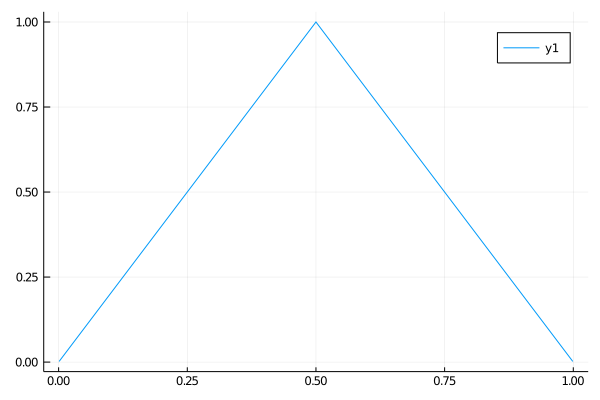

In [39]:
##Test pour vérifier que la fonction convert fonctionne bien
Utab = zeros((1,1))
Utab[1,1] = 1

Wtab = convert_(Utab) 
# print(size(Wtab))

plot(xvec, Wtab)

In [40]:
closeall()

Dans la suite du code, nous allons tracer l'évolution des erreurs 
$$
\|u_h - u_{h_{ref}}\|_{L^2(]0,T[,H^1_0(0,1))} 
$$
et 
$$
\max_{t\in [0,T]} \|u_h(t) - u_{h_{ref}}(t)\|_{L^2(0,1)}
$$
en fonction de $h$ pour des valeurs de $h$ bien plus grandes que $h_{ref}$, ou du moins une approximation de ces normes. 

Pour cela, une première étape va être de calculer la norme $L^2(0,1)$ et la norme $H^1_0(0,1)$ d'un élement de $V_{h_{ref}}$.  

5) Soit $u\in V_{h_{ref}}$ tel que 
$$
u = \sum_{i=1}^{N_{h_{ref}}} U_i \phi_i^{h_{ref}}.
$$
Montrer que 
$$
\|u \|_{L^2(0,1)}^2 = U^T S_{h_{ref}} U
$$
et que 
$$
\left\|\frac{d}{dx}u\right\|^2_{L^2(0,1)} = U^T K_{h_{ref}}U,
$$
où $U = (U_i)_{1\leq i \leq N_{h_{ref}}}$.

REPONSE:
$$
\begin{align*}
\|u\|_{L^2(0,1)}^2 &= \|\sum_{i=1}^{N_{href}}U_i\phi_i^{href}\|_{L^2(0,1)}^2\\
             &= \int_{x\in[0,1]}\lbrack\sum_{i=1}^{N_{href}}U_i\phi_i^{href}\rbrack^2\\
             &= \int_{x\in[0,1]}\lbrack\sum_{i=1}^{N_{href}}U_i\phi_i^{href}\rbrack \lbrack\sum_{j=1}^{N_{href}}U_j\phi_j^{href}\rbrack\\ 
             &= \sum_{i=1}^{N_{href}}\sum_{j=1}^{N_{href}} U_i*(\int_{x\in[0,1]}\phi_i^{href}\phi_j^{href})*U_j \\
             &= U^T S_{href} U.
\end{align*}
$$
car $\frac{d}{dx}u = \sum_{i=1}^{N_{h_{ref}}} U_i \frac{d}{dx}\phi_i^{h_{ref}}$
$$
\begin{align*}
\|\frac{d}{dx}u\|_{L^2(0,1)}^2 &= \|\sum_{i=1}^{N_{href}}U_i \frac{d}{dx}\phi_i^{href}\|_{L^2(0,1)}^2\\
                     &= \int_{x\in[0,1]}\lbrack\sum_{i=1}^{N_{href}}U_i \frac{d}{dx}\phi_i^{href}\rbrack^2\\
                     &= \int_{x\in[0,1]}\lbrack\sum_{i=1}^{N_{href}}U_i \frac{d}{dx}\phi_i^{href}\rbrack \lbrack\sum_{j=1}^{N_{href}}U_j \frac{d}{dx}\phi_j^{href}\rbrack\\ 
                     &= \sum_{i=1}^{N_{href}}\sum_{j=1}^{N_{href}} U_i*(\int_{x\in[0,1]}\frac{d}{dx}\phi_i^{href}\frac{d}{dx}\phi_j^{href})*U_j \\
                     &= U^T K_{href} U.
\end{align*}
$$

Remplir les lignes de code correspondantes dans les cellules ci-dessous.

In [44]:
##Calcule \|u\|_{L^2(0,1)}
# Ici U est un tableau de taille Nhref
function normL2_space(U,Nhref) 
    Shref = Sh(Nhref);
    # print(size(U'*Shref*U))
    return U'*Shref*U ## TO COMPLETE
end

normL2_space (generic function with 1 method)

In [45]:
##Calcule \|d_x u\|_{L^2(0,1)}
# Ici U est un tableau de taille Nhref
function normL2_derivative_space(U,Nhref)
    Khref = Kh(Nhref);
    return U'*Khref*U ## TO COMPLETE
end

normL2_derivative_space (generic function with 1 method)

Dans la suite, pour une fonction $u\in L^2(]0,T[, V_{h_{ref}})$ suffisamment régulière, nous allons approcher la quantité 
$$
\|u \|_{L^2(]0,T[; L^2(0,1))}^2
$$
par une formule des trapèzes en temps, c'est-à-dire par 
$$
A_1:=\frac{1}{2}\Delta t\|u(t_0)\|_{L^2(0,1)}^2 +  \sum_{p=1}^{P-1} \Delta t \|u(t_p)\|_{L^2(0,1)}^2 + \frac{1}{2}\Delta t\|u(t_P)\|_{L^2(0,1)}^2. 
$$
Le temps initial $t_0=0$ et le temps final $t_P=T$ sont donc pris en compte avec un facteur moitié.

De la même manière, nous allons approcher 
$$
\left\|\frac{d}{dx}u \right\|_{L^2(]0,T[; L^2(0,1))}^2
$$
par 
$$
A_2:=\frac{1}{2}\Delta t \left\|\frac{d}{dx}u(t_0)\right\|_{L^2(0,1)}^2 + \sum_{p=1}^{P-1} \Delta t \left\|\frac{d}{dx}u(t_p)\right\|_{L^2(0,1)}^2 + \frac{1}{2}\Delta t\left\|\frac{d}{dx}u(t_P)\right\|_{L^2(0,1)}^2.
$$
Ainsi, la quantité $\|u \|_{L^2(]0,T[; H_0^1(0,1))}^2$ sera approchée par $A_1+A_2$. 

Remplir l'expression de ces normes en utilisant les fonctions normL2_space et normL2_derivative_space définies précédemment. Attention à ne pas calculer les normes au carré, mais bien les normes!  

In [46]:
##Calcule l'approximation de \|u\|_{L^2(]0,T[,L^2(0,1))}
# Ici U est un tableau de taille Nhref * (P+1)
function normL2_space_time(U,Nhref,P) 
    ## TO COMPLETE
    normL2_space0 = normL2_space(U[:,1],Nhref);
    A1 = 1/2*Deltat(P)*normL2_space0;
    # print(A1)
    for i in 2:(P-1) 
        normL2_space_i = normL2_space(U[:,i],Nhref);
        A1 += Deltat(P)*normL2_space_i;
    end
    normL2_spaceP = normL2_space(U[:,P],Nhref);
    A1 += 1/2*Deltat(P)*normL2_spaceP;
    return A1
end

normL2_space_time (generic function with 1 method)

In [47]:
##Calcule l'approximation de \|\d_x u\|_{L^2(]0,T[,L^2(0,1))}
# Ici U est un tableau de taille Nhref * (P+1)
function normL2_derivative_space_time(U,Nhref,P) 
    ## TO COMPLETE
    normL2_ds_0 = normL2_derivative_space(U[:,1],Nhref);
    A2 = 1/2*Deltat(P)*normL2_ds_0;
    # print(size(A2))
    for i in 2:(P-1) 
        normL2_ds = normL2_derivative_space(U[:,i],Nhref);
        A2 += (Deltat(P)* normL2_ds);
    end
    normL2_ds_P = normL2_derivative_space(U[:,P],Nhref);
    A2 += 1/2*Deltat(P)*normL2_ds_P;
    return A2
end

normL2_derivative_space_time (generic function with 1 method)

In [48]:
##Calcule l'approximation de \|u\|_{L^2(]0,T[,H^1_0(0,1))}
# Ici U est un tableau de taille Nhref * (P+1)
function normH1_space_time(U,Nhref,P)
    ## TO COMPLETE
    A1 = normL2_space_time(U,Nhref,P);
    A2 = normL2_derivative_space_time(U,Nhref,P);
    A = A1+A2
    return A
end

normH1_space_time (generic function with 1 method)

Passons maintenant au calcul de ces erreurs. Nous n'utiliserons ici que le schéma de Cranck-Nicholson pour la discrétisation en temps. Remplir les lignes de code correspondantes.

In [163]:
## Contient les différentes valeurs de Nh pour lesquelles nous allons calculer les erreurs
Nhtab = [2-1,4-1,8-1,16-1,32-1,64-1,128-1, 256-1] 

##Tableaux qui vont contenir les valeurs des différentes erreurs obtenues
## soit max en temps et L^2 en espace
errtab_max_L2_Nh = []

## soit L^2 en temps et H^1_0 en espace
errtab_L2_H10_Nh = []

for Nh in Nhtab
    U = sol_chaleur(Nh,P,0.5); # contient l'approximation de la solution de la chaleur pour Nh et P 
    
    # convertit les coordonnées de U dans la base des \phi_i^h en ses coordonnées transformées dans la base des \phi_i^{h_{ref}}
    W = convert(U) ;
    
    err_max_L2 = 0;
    for p in 1:(P+1)
        
        #Contient l'erreur L^2 en espace à l'instant t_p entre la solution calculée avec Nh et la solution calculée avec Nhref
        err = normL2_space((W-Wref)[:,p],Nhref);##TO COMPLETE
        # print(size(err))
        err_max_L2 = max(err_max_L2,err);
    end
        
    append!(errtab_max_L2_Nh,err_max_L2);
    
    #Contient l'erreur L^2 en temps et H^1_0 en espace entre la solution calculée avec Nh et la solution calculée avec Nhref
    err_L2_H10 = normH1_space_time( W-Wref,Nhref,P)## TO COMPLETE
        
    append!(errtab_L2_H10_Nh,err_L2_H10);
end

Les lignes de code ci-dessous permettent de tracer ces erreurs en échelle logarithmique en fonction de $N_h$ pour les deux normes choisies ci-dessus. 

Compléter ces lignes de code pour afficher les abscisses, les ordonnées et les labels des différentes courbes tracées.  

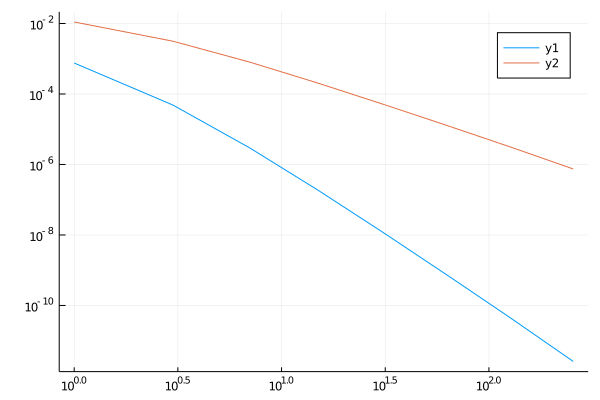

In [164]:
plot(Nhtab,[errtab_max_L2_Nh, errtab_L2_H10_Nh], xaxis=:log, yaxis=:log)

In [47]:
closeall()

6) A quelle vitesse en fonction de $h$ décroissent les erreurs
$$
\max_{t\in[0,T]} \|u(t) - u_h(t)\|_{L^2(0,1)}
$$
et 
$$
\| u - u_h \|_{L^2([0,T], H_{0}^{1}(0,1))}
$$
(ou plutôt leurs approximations discrétisées en temps)? Si besoin faire une régression linéaire.  

In [57]:
import Pkg; 
Pkg.add("GLM")
Pkg.add("DataFrames")
using GLM,DataFrames

  Resolving package versions...
   Updating `C:\Users\sfber\.julia\environments\v1.4\Project.toml`
 [no changes]
   Updating `C:\Users\sfber\.julia\environments\v1.4\Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `C:\Users\sfber\.julia\environments\v1.4\Project.toml`
 [no changes]
   Updating `C:\Users\sfber\.julia\environments\v1.4\Manifest.toml`
 [no changes]


In [168]:
x=log.(Nhtab)
# print(x)
y= -log.(errtab_max_L2_Nh)
# print(y)
dataregression = DataFrame(x = x,y = y);
lm(@formula(y ~ x),dataregression)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

y ~ 1 + x

Coefficients:
──────────────────────────────────────────────────────────────────────────
             Estimate  Std. Error  t value  Pr(>|t|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)   6.27247    0.383509  16.3555     <1e-5    5.33406    7.21089
x             3.58471    0.111024  32.2876     <1e-7    3.31304    3.85638
──────────────────────────────────────────────────────────────────────────

In [169]:
x=log.(Nhtab)
# print(x)
y= -log.(errtab_L2_H10_Nh)
# print(y)
dataregression = DataFrame(x = x,y = y);
lm(@formula(y ~ x),dataregression)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

y ~ 1 + x

Coefficients:
──────────────────────────────────────────────────────────────────────────
             Estimate  Std. Error  t value  Pr(>|t|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)   3.97938   0.220448   18.0513     <1e-5    3.43996    4.51879
x             1.77155   0.0638187  27.7591     <1e-6    1.61539    1.92771
──────────────────────────────────────────────────────────────────────────

REPONSE: 

$\mbox{la vitesse sous critère  }\max_{t\in[0,T]} \|u(t) - u_h(t)\|_{L^2(0,1)}$ : 
$$
O(h^{3.58471})
$$
$\mbox{la vitesse sous critère  }\| u - u_h \|_{L^2([0,T], H_{0}^{1}(0,1))}$ : 
$$
O(h^{1.77155})
$$

# IV- Méthode Proper Orthogonal Decomposition

Le but de la dernière partie de ce TP est de vous présenter une introduction à la méthode de réduction de modèles appelée Proper Orthogonal Decomposition. 

Celle-ci est typiquement utilisée dans le contexte suivant: imaginez que vous ayez besoin d'approcher numériquement la solution d'une équation de la chaleur dans un milieu hétérogène du type
$$
\left\{
\begin{array}{ll}
\partial_t u(t,x) - \partial_x (c(x) \partial_x u(t,x)) = f(t,x), & \quad (t,x)\in ]0,T[\times (0,1)\\
u(0,x) = g(x), & \quad x\in (0,1),\\
\end{array}
\right.
$$
pour un grand nombre de fonctions $c:(0,1) \to \mathbb{R}$, appelées coefficient de diffusion.

Nous ferons ici l'hypothèse que tous ces coefficients de diffusion vérifieront l'hypothèse qu'il existe $0< \alpha, \beta < +\infty$ tels que 
$$
\alpha \leq c(x) \leq \beta. 
$$
Nous admettrons que sous ces hypothèses, il existe toujours une unique solution faible au problème ci-dessus. 

La méthode POD consiste à:

Etape 1: Résoudre numériquement avec une méthode d'éléments finis (avec une discrétisation spatiale a priori très fine) l'équation ci-dessus pour une valeur du coefficient de diffusion $c_0(x)$ particulière. Dans notre cas, nous prendrons $c_0(x) = 1$, de sorte que le problème ci-dessus sera tout simplement l'équation de la chaleur vue dans les premières parties du TP. Notons $u_0(t,x)$ la solution de cette équation.

Etape 2: Calculer la décomposition en composantes principales (vue dans le DM) de la fonction $u_0(t,x)$. Plus précisément pour une certaine valeur $n\in \mathbb{N}^*$, nous allons calculer $(e_1,\cdots,e_n)\in H^1_0(0,1)$ de telle sorte que 
$$
A_{u_0} e_k = \mu_k e_k
$$
où $A_{u_0}$ est l'opérateur défini dans le DM pour l'espace $V = H^1_0(0,1)$. 

Etape 3: L'équation ci-dessus (avec un coefficient de diffusion $c$ quelconque) est approchée numériquement par une méthode de Galerkin utilisant l'espace de discrétisation $V^n:= {\rm Vect}\{e_1, \cdots, e_n\}$ où les fonctions $e_1, \cdots, e_n$ sont celles qui ont été calculées à l'étape 2 (ou une approximation numérique de celles-ci).

Le but de cette dernière partie du TP est d'étudier numériquement le comportement de cette méthode.

Commençons par la mise en oeuvre de l'étape 1 de la méthode POD.

Commençons par résoudre l'équation de la chaleur pour une certaine valeur de $N_h$ et $P$. On utilisera toujours ici un schéma de Cranck-Nicholson. 

In [24]:
##Nouvelles valeurs de Nh et P qui seront fixées une fois pour toutes dans la suite
Nh = 299;
P = 500;

dt = Deltat(P);
dx = Deltax(Nh);

U_0 = sol_chaleur(Nh,P,0.5);

Passons maintenant à l'étape 2 de la méthode POD: nous allons calculer la décomposition en valeurs singulières (approchée) de $u_0(t,x)$ en utilisant la méthode décrite dans votre DM préparatoire. Nous reprenons ici les mêmes notations que dans votre DM et notons, pour tout $n\in \mathbb{N}^*$, $(\mu_n^{app}, E_n^{app})\in \mathbb{R}\times \mathbb{R}^{N_h}$ les solutions du problème aux valeurs propres généralisés
$$
B^{app}E_n^{app} = \mu_n^{app} M E_n^{app}
$$
où les matrices $B^{app}$ et $M$ sont les matrices définies dans la deuxième partie du DM. 

On rappelle que $\mu_n^{app}$ est une approximation de $\mu_n$ la $n^{eme}$ plus grande valeur propre de l'opérateur $A_{u_0}$ et que 
$$
e_n^{app}:= \sum_{i=1}^{N_h} E_{n,i}^{app} \phi_i^h
$$
est une approximation de $e_n$, vecteur propre de $A_{u_0}$ associé à la valeur propre $\mu_n$.  

1) Rappeler l'expression de la matrice $M$ introduite dans le DM. Remplir son expression dans les lignes de code ci-dessous.

REPONSE:

In [25]:
M = Sh(Nh)+Kh(Nh);## TO COMPLETE

2) Rappeler l'expression de la matrice $C$ introduite dans le DM. Remplir son expression dans les lignes de code ci-dessous.  

REPONSE:

In [26]:
C = U_0;## TO COMPLETE

3) Rappeler l'expression de la matrice $B^{app}$ introduite dans le DM. Remplir son expression dans les lignes de code ci-dessous.

REPONSE: 

In [27]:
Bapp = M*C*(M*C)'*dt;##TO COMPLETE

Dans les lignes de code ci-dessous, on calcule la décomposition en composantes principales (approchée) du signal $u_0$. On rappelle que celle-ci est obtenue en résolvant un problème aux valeurs propres généralisés. 

In [28]:
#On calcule la décomposition en composantes principales du signal U_0
print("Calcul de la décomposition en composantes principales du signal U_0")
vecs = eigvecs(Bapp,M);
vals = eigvals(Bapp,M)


#= 299-element Array{Float64,1}:
 -2.924372086284801e-19 
 -1.3072539919353597e-21
 -2.8948459891776148e-22
 -2.4605782196972743e-22
 -2.426157080835343e-22 
 -1.956324579778269e-22 
 -1.5236434618987053e-22
 -1.3834263484657262e-22
 -1.3095557425932017e-22
 -1.2696582665300696e-22
 -1.1037441616139028e-22
 -9.452990982665223e-23 
 -8.952463905036024e-23 
  ⋮                     
  3.880747236774988e-15 
  1.1825004726735703e-14
  3.5305056967750025e-14
  1.1135907023495898e-13
  3.9809350482010707e-13
  1.6834401191427185e-12
  8.925352979885917e-12 
  7.396611244391158e-11 
  1.5301768492730824e-9 
  8.823552569370522e-8  
  0.0001391519114583672 
  0.06753587167959331 
=#

Calcul de la décomposition en composantes principales du signal U_0

299-element Array{Float64,1}:
 -3.82389745579357e-21
 -2.5505544428011086e-21
 -1.0373250500081548e-21
 -1.8874586763257399e-22
 -1.8092983088854018e-22
 -1.79868528897331e-22
 -1.683695319216555e-22
 -1.4905160994809874e-22
 -1.3249753171021134e-22
 -1.1979289136822778e-22
 -1.131221586551989e-22
 -1.1146822436640298e-22
 -1.0829122094084168e-22
  ⋮
  2.8046198735601887e-15
  9.0606176132481e-15
  2.7655161207713633e-14
  8.54236643913742e-14
  2.910388964248014e-13
  1.1497835876581616e-12
  5.526215146137988e-12
  3.544451791436195e-11
  4.679322574658266e-10
  2.3173901394128313e-8
  3.7848071482765204e-5
  0.061166469904748645

Les lignes de code suivantes permettent de tracer les valeurs propres $(\mu_n)_{1\leq n \leq N_h}$ en fonction de $n$. Attention! Celles-ci sont automatiquement ordonnées de la valeur la plus petite à la plus grande (donc l'ordre inverse de celui que l'on souhaiterait). Compléter ces lignes de code pour afficher les abscisses, ordonnées et labels. 

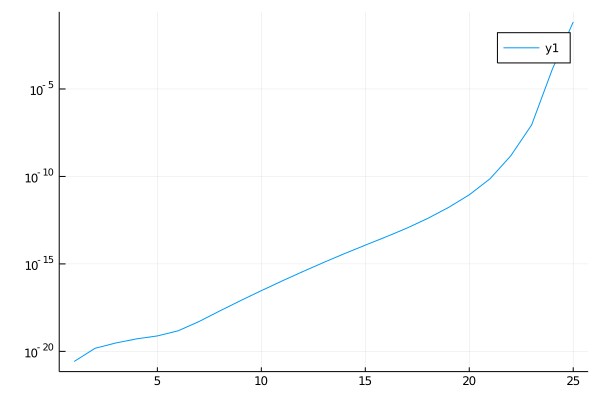

In [34]:
plot(1:25, vals[Nh-24:Nh], yaxis=:log)

In [35]:
closeall()

4) Qu'observez-vous quant à la vitesse de décroissance des $(\mu_n)_{1\leq n \leq N_h}$? 

REPONSE:

Pour le cas $n\leq20$,on voit une décroissance linéaire. Après $n=20$, cette vitesse augumente.  

Nous pouvons maintenant passer à l'étape 3 de la méthode POD. 

Nous rappelons que pour tout $1\leq n\leq N_h$, on définit
$$
e_n^{app}:= \sum_{i=1}^{N_h} (E_n^{app})_i \phi^h_i.
$$

Nous allons commencer par étudier l'erreur d'approximation d'une méthode de Galerkin associée à l'espace $V^n = {\rm Vect}\{e_1^{app}, \cdots, e_n^{app}\}$ dans le cas où le coefficient de diffusion est égal à $c(x) = c_0(x) = 1$. Mais il faut garder en tête que, dans la méthode POD en pratique, si la valeur du coefficient de diffusion $c(x)$ est modifiée, l'espace de discrétisation reste quant à lui inchangé, ce qui fait qu'on ne calcule la décomposition en composantes principales que d'un seul signal. Cela fera l'objet de la dernière question du TP.

Nous notons dans la suite $u^n$ la solution approchée de l'équation obtenue par l'approximation de Galerkin dans l'espace discrétisé $V^n$. Pour presque tout $t\in [0,T]$, soit $D(t):=(d_1(t), \cdots, d_n(t)) \in \mathbb{R}^n$ les coordonnées de $u^n(t)$ dans la base $(e_1^{app}, \cdots, e_n^{app})$. 

Nous noterons dans la suite, pour une certaine valeur de $1\leq n\leq N_h$, les matrices $K^n:=(K^n_{kl})_{1\leq k,l \leq n},\; S^n:=(S^n_{kl})_{1\leq k,l \leq n} \in \mathbb{R}^{n\times n}$ définies par
$$
S^n_{kl} = \langle e^{app}_k, e^{app}_l \rangle_{L^2(0,1)} \quad \mbox{ et } \quad K_{kl} = \int_0^1 \frac{d}{dx}e_k^{app}(x) \frac{d}{dx}e_l^{app}(x)\,dx.
$$

On note $E^n$ la matrice de taille $N_h \times n$ dont la $k^{eme}$ colonne est donnée par le vecteur $E^{app}_k$.  

5) Montrer que 
$$
S^n = (E^n)^T S_h E^n \quad \mbox{ et } \quad K^n = (E^n)^T K_h E^n.
$$

REPONSE:

\begin{align*}
S^n_{ij} &= \langle e^{app}_i, e^{app}_j \rangle_{L^2(0,1)}\\
&= \langle \sum_{k=1}^{N_h}(E_i^{app})_k \phi^h_k, \sum_{l=1}^{N_h}(E_j^{app})_l \phi^h_l \rangle_{L^2(0,1)} \\
&= \sum_{k=1}^{N_h}\sum_{l=1}^{N_h}(E_i^{app})_k \langle \phi^h_k,\phi^h_l \rangle_{L^2(0,1)}(E_j^{app})_l \\
&= \sum_{k=1}^{N_h}\sum_{l=1}^{N_h}(E_i^{app})_k S_{h,kl} (E_j^{app})_l 
\end{align*}

\begin{align*}
K^n_{ij} &= \int_{0}^{1}\frac{d}{dx}e_i^{app}(x) \frac{d}{dx} e_j^{app}(x)\ dx\\
&= \int_{0}^{1}\frac{d}{dx} \sum_{k=1}^{N_h}(E_i^{app})_{k}\phi^h_k\ \frac{d}{dx} \sum_{l=1}^{N_h}(E_j^{app})_{l}\phi_{l}^{h}\ dx\\
&= \sum_{k=1}^{N_h}\sum_{l=1}^{N_h} (E_i^{app})_{k}\int_{0}^{1}\frac{d}{dx} \phi^h_k\ \frac{d}{dx}\phi^{h}_{l}\ dx\ (E_j^{app})_{l}\\
&= \sum_{k=1}^{N_h}\sum_{l=1}^{N_h} (E_i^{app})_{k}K_{h,kl}(E_j^{app})_{l}\\  
\end{align*}

6) Montrer que le vecteur $D(t)$ est solution de l'EDO
$$
S^n \frac{d}{dt}D(t) + K^n D(t) = F^n(t)
$$
où 
$$
F^n(t) = (E^n)^T F_h(t).
$$

REPONSE: 

Rappelons la forme variationnelle de l'équation de la chaleur. Soit $u\in L^2((0;T),H^1_0(\Omega))$ telle que $u'=u\in L^2((0;T),H^{-1}(\Omega))$
\begin{align*}
\langle u'(t),v\rangle_{H^{-1}(\Omega),H^1_0(\Omega)}+\int_{\Omega}\nabla u(t)\cdot \nabla v=\langle f(t),v\rangle_{L^2(\Omega)} 
\end{align*}
D'où $v\in H^1_0(\Omega)$ et presque partout en $t\in (0,T)$. On écrit $u^n(t)$ sous la base $E^{app}$, ce qui est aussi la distribution de notre variationnelle ci-dessus.  
\begin{align*}
u^n(t)=\sum_{j=1}^{n}d_j(t)e_j^{app}
\end{align*}
On trouve que $u^n(t)$ doit vérifier que
\begin{align*}
\sum_{i=1}^{n}\langle e_i^{app},\sum_{j=1}^{n}d'_j(t)e_j^{app}\rangle_{L^2(\Omega)}+\sum_{i=1}^{n}\int_{\Omega}\frac{d}{dx}e_i^{app}\frac{d}{dx}\sum_{j=1}^{n}d_j(t)e_j^{app}&=\sum_{i=1}^{n}\langle f(t),e_i^{app}\rangle_{L^2(\Omega)}\\
\sum_{i=1}^{n}\sum_{j=1}^{n}\langle e_i^{app},e_j^{app}\rangle_{L^2(\Omega)}d'_j(t)+\sum_{i=1}^{n}\sum_{j=1}^{n}\int_{\Omega}\frac{d}{dx}e_i^{app}\frac{d}{dx}e_j^{app}\ d_j(t)&=\sum_{i=1}^{n}\langle f(t),e_i^{app}\rangle_{L^2(\Omega)}\\
\sum_{i=1}^{n}\sum_{j=1}^{n}S^n_{ij}d'_j(t)+\sum_{i=1}^{n}\sum_{j=1}^{n}K^n_{ij}d_j(t)&=\sum_{i=1}^{n}\langle r(t)s(x),\sum_{l=1}^{N_h}(E_i^{app})_l\phi_{l}{h}\rangle_{L^2(\Omega)}\\
\sum_{i=1}^{n}\sum_{j=1}^{n}S^n_{ij}d'_j(t)+\sum_{i=1}^{n}\sum_{j=1}^{n}K^n_{ij}d_j(t)&=r(t)\sum_{i=1}^{n}\sum_{l=1}^{N_h}(E_i^{app})_l \langle s(x),\phi_{l}{h}\rangle_{L^2(\Omega)}\\
\end{align*}
Rappelons que $\overline{F}_h = (\overline{F}_{h,i})_{1\leq i \leq N_h},\;
\overline{F}_{h,i}=\langle s(x),\phi^h_i\rangle_{L^2(0,1)}$
\begin{align*}
S^nD'(t)+K^nD(t)&=r(t)(E^n)^{T}\overline{F}_h
\end{align*}
On note $F_h(t)=r(t)\overline{F}_h$
$$
S^nD'(t)+K^nD(t)=(E^n)^{T}F_h(t)
$$

7) Montrer que
$$
F^n(t) = r(t) \overline{F}^n,
$$
où 
$$
\overline{F}^n = (E^n)^T \overline{F}_h.
$$

REPONSE:

La démonstration précédente nous donne $F^n(t)=r(t)(E^n)^{T}\overline{F}_h$. Si on note $\overline{F}^n=(E^n)^{T}\overline{F}_h$, on obtiendra $F^n(t) = r(t) \overline{F}^n$.

8) Ecrire l'expression du $\theta$-schéma associé à un pas de temps $\Delta t>0$ pour résoudre l'EDO dont $D(t)$ est solution. 

REPONSE:

On définit également, si $f$ est suffisamment régulière, pour tout $0\leq p\leq P$,
$$
F_h^p=F_h(t_p)
$$
On le $\theta$-schéma à discrétiser $D(t)$ en temps, pour $\theta\in[0,1]$:
\begin{align*}
S^n\frac{D^{p+1}-D^{p}}{\Delta t}+K^n(\theta D^{p+1}+(1-\theta)D^{p})&=\theta F_h^{p+1}+(1-\theta)F_h^p\\
(S^n+\theta\Delta tK^n)D^{p+1}&=(S^n-(1-\theta)\Delta tK^n)D^{p}+\Delta t (\theta\ r(t_{p+1})\overline{F}^n +(1-\theta)\ r(t_{p})\overline{F}^n)
\end{align*}

9) Montrer que $C(0) = 0$. 

REPONSE:

Pour tout $j=1,...,n$, $\langle u_h(0),e_j \rangle_{L^2}=\langle g,e_j \rangle_{L^2} $.\\
$$
\sum_{i=1}^{n}D_i(0)(S_h)_{ij}=\langle g,e_j \rangle_{L^2}
$$
Car $g=0$, il faut tous les $D_i(0)=0$ soit $D(0)=0$.Donc $C(0)=D(0)=0$

10) Montrer enfin que pour presque tout $t\in [0,T]$,
$$
u^n(t) = \sum_{i=1}^{N_h} U^n_i(t) \phi^h_i,
$$
où $U^n(t)\in \mathbb{R}^{N_h}$ est donné par
$$
U^n(t) = E^n {D(t)}^T.
$$

REPONSE: 

\begin{align*}
u^n(t) 
&= \sum_{j=1}^{n}d_j(t)e_j^{app}\\
&= \sum_{j=1}^{n}d_j(t)\sum_{i=1}^{N_h} (E_j^{app})_i \phi^h_i\\
&= \sum_{i=1}^{N_h} \sum_{j=1}^{n}(E_j^{app})_i d_j(t)\phi^h_i\\
\end{align*}
ce qui montre que:
$$
U_i^n(t)=\sum_{j=1}^{n}(E_j^{app})_i d_j(t)\rightleftharpoons U^n(t)=E^n {D(t)}^T
$$
$$
u^n(t)=\sum_{i=1}^{N_h}U_i^n(t)\phi^h_i
$$

Le but des lignes de code suivantes est d'implémenter un $\theta$-schéma pour résoudre l'EDO dont le vecteur $D(t)$ est solution. Les arguments de la fonction ci-dessous sont $\theta$ et $n$. Remplir les lignes de code correspondantes. Les différentes approximations de $D(t_p)$ pour $0\leq p \leq P$ sont stockées dans un tableau appelé Dtab. La fonction renvoie un tableau Utab dans lequel sont stockées les approximations des vecteurs 
$U^n(t_p) = E^nD(t_p)$.

In [22]:
function sol_chaleur_POD(n,theta)
    
    #En est un tableau de taille Nh * n: la k^eme colonne de En contient le vecteur E^{app}_k
    En = zeros((Nh,n)) 
    for k in 1:n
        En[:,k] = vecs[:,Nh-k+1]
    end
        
    ##Définition des matrices Sn, Kn, Fbarn    
    Sn = En'*Sh(Nh)*En ## TO COMPLETE
    Kn = En'*Kh(Nh)*En ## TO COMPLETE
    Fbarn = En'*Fbarh(Nh) ## TO COMPLETE
    
    ## Dtab va contenir les valeurs de D^p pour tout 0\leq p \leq P
    Dtab = zeros((n,P+1));
    
    ## Dold représente la valeur de D^p
    Dold = zeros(n)
    Dtab[:,1] = Dold;
    
    ## Temps, pour le entrer dans r(t)
    t=0
    dt = Deltat(P)
    
    for p in 0:(P-1)
        t +=dt
        # print(size((Sn-(1-theta)*dt*Kn)*Dold))
        # print(size(En'*Fbarn))
        B = (Sn-(1-theta)*dt*Kn)*Dold + dt*(theta*r(t)*Fbarn+(1-theta)*r(t-dt)*Fbarn) ## TO COMPLETE
        size(B)
        A = Sn+theta*dt*Kn ## TO COMPLETE
        size(A)
 
        #Dnew représente la valeur de $D^{p+1}
        Dnew = A\B
        Dtab[:,p+2] = Dnew 
        Dold = Dnew
    end
       
    # Utab contient les coordonnées des approximations des vecteurs U^n(t_p)
    Utab = En*Dtab ## TO COMPLETE
        
    return Utab
end

sol_chaleur_POD (generic function with 1 method)

Calculons la solution approchée de l'équation de la chaleur par la méthode POD pour $n = 5$ avec un schéma de Cranck-Nicholson. 

In [52]:
Utab = sol_chaleur_POD(5, 0.5);

L'objectif des lignes suivantes est d'afficher une animation pour observer l'évolution de la solution approchée $u^n(t)$.

┌ Info: Saved animation to 
│   fn = E:\codeJUPYTER\Julia Scripts\TD_POD\anim_un_scheme.gif
└ @ Plots C:\Users\sfber\.julia\packages\Plots\kgqnU\src\animation.jl:102


Plots.AnimatedGif("E:\\codeJUPYTER\\Julia Scripts\\TD_POD\\anim_un_scheme.gif")
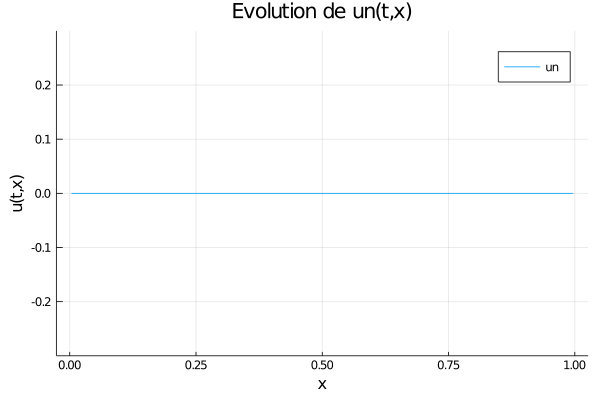

In [53]:
anim5 = @animate for p in 1:(P+1)
    plot(xgrid(Nh), Utab[:,p], ylims = (-0.3, 0.3), title = "Evolution de un(t,x)", label = "un", xlabel = "x", ylabel = "u(t,x)")
end
gif(anim5, "anim_un_scheme.gif", fps = 15)

In [54]:
closeall()

11) Est-ce que la solution obtenue par la méthode POD vous semble proche visuellement de la solution de l'équation de la chaleur? Quelle est la dimension de l'espace de discrétisation utilisé ici? Quelle est la valeur de $N_h$? Commentez sur l'intérêt d'utiliser cette méthode POD ici. 

REPONSE:

Nous allons maintenant passer au calcul des erreurs
$$
\|u_h -u^n\|_{L^2(]0,T[, H^1_0(0,1))} 
$$
et 
$$
{\max}_{t\in [0,T]}\|u_h(t) -u^n(t)\|_{L^2(0,1)} .
$$
En utilisant les fonctions définies à la partie 3 du TP, remplir les lignes de code ci-dessous. 

In [55]:
#Tableau qui contient les différentes valeurs de n pour lesquelles la solution approchée par méthode POD va être calculée
ntab = [2,4,6,8,10,15,20,50]

#Tableaux vides qui vont contenir les valeurs des différentes erreurs
#soit max en temps L2 en espace
errtab_max_L2_Nh = []

# soit L2 en temps et H^1_0 en espace
errtab_L2_H10_Nh = []

for n in ntab
    #Calcul de la solution approchée par méthode POD avec un schéma de Cranck-Nicholson
    Un = sol_chaleur_POD(n,0.5);
    
    err_max_L2 = 0;
    for p in 1:(P+1)
        err = normL2_space((Un-U_0)[:,p],Nh);## TO COMPLETE
        err_max_L2 = max(err_max_L2,err);
    end
        
    append!(errtab_max_L2_Nh,err_max_L2)
    
    
    err_L2_H10 = normH1_space_time( Un-U_0,Nh,P);## TO COMPLETE
        
    append!(errtab_L2_H10_Nh,err_L2_H10)
end

Les lignes de code ci-dessous permettent de tracer ces erreurs en fonction de $n$. Compléter les abscisses, ordonnées et labels des courbes tracées.

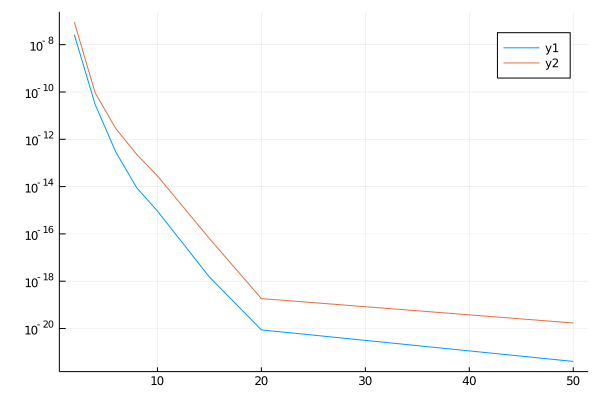

In [56]:
plot(ntab,[errtab_max_L2_Nh,errtab_L2_H10_Nh], yaxis=:log )

In [61]:
closeall()

12) Comment est-ce que ces erreurs évoluent en fonction de $n$? Comparer avec les erreurs et les vitesses obtenues à la partie 3 en fonction de $h$ (ou de $N_h$).

REPONSE:  

In [59]:
x=log.(ntab)
# print(x)
y= -log.(errtab_max_L2_Nh)
# print(y)
dataregression = DataFrame(x = x,y = y);
lm(@formula(y ~ x),dataregression)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

y ~ 1 + x

Coefficients:
───────────────────────────────────────────────────────────────────────────
             Estimate  Std. Error   t value  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────────
(Intercept)   10.244     1.96935    5.20173    0.0020     5.4252    15.0628
x             10.7484    0.813786  13.2079     <1e-4      8.7571    12.7396
───────────────────────────────────────────────────────────────────────────

In [60]:
x=log.(ntab)
# print(x)
y= -log.(errtab_L2_H10_Nh)
# print(y)
dataregression = DataFrame(x = x,y = y);
lm(@formula(y ~ x),dataregression)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

y ~ 1 + x

Coefficients:
───────────────────────────────────────────────────────────────────────────
             Estimate  Std. Error   t value  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────────
(Intercept)   9.52333    1.93963    4.90988    0.0027    4.77723    14.2694
x             9.84842    0.801504  12.2874     <1e-4     7.88721    11.8096
───────────────────────────────────────────────────────────────────────────


On fixe "n=10" pour comparer les erreurs ci-dessous:
$$
\begin{array}{ccc}
      & POD & FEM \\
L^2(0,1)& \approx 10^{-15} & \approx 10^{-6} \\
H_{0}^{1}(0,1) & \approx 10^{-13.5} & \approx 10^{-3.2}
\end{array}
$$
On compare les vitesses ci-dessous:
$$
\begin{array}{ccc}
      & POD & FEM \\
L^2(0,1)&O(h^{10.7484})&O(h^{3.58471})\\
H_{0}^{1}(0,1))&O(h^{9.84842})&O(h^{1.77155})\\
\end{array}
$$

POD décroit beaucoup plus rapidement que Méthode des éléments finis. Et ce n'est pas seulement son avantage.Il faut remarquer que même si on change notre cirtère de $L^2$ à $H_{0}^{1}$, on ne perd pas de vitesse(presque ça). C'est-à-dire cette méthode converge "Globalement" par rapport à la dimension de l'espace de solution. Un seul souci pour POD se trouve sur le temps pris dans l'étape 2 où on fait la décomposition en composantes principales. Parce que si on a une problème qui a une dimension énorme comme 1,000,000 $\times$ 1,000,000, vu constamment dans le monde mécanique, le calcul sera très lourd. 

13) (Question facultative) Nous pouvons à présent passer à l'étape 3 de la méthode POD, mais cette fois-ci pour une valeur différente du coefficient de diffusion c(x). 

Implémenter la méthode POD pour approcher la solution de l'équation définie en début de partie pour une valeur du coefficient de diffusion $c(x) = 2$, par une méthode de Galerkin avec l'espace de discrétisation $V^n = {\rm Vect}\{e_1^{app}, \cdots, e_n^{app}\}$. On rappelle que les étapes 1 et 2 de la méthode POD sont indépendantes du choix de $c$, qu'elles ont été faites une bonne fois pour toute (en considérant le coefficient $c_0$), et que seule l'étape 3 de la méthode POD doit être refaite ici.

Calculer et afficher les différents types d'erreur étudiés dans cette partie par rapport à une solution de référence (pour calculer cette solution de référence, on pourra utiliser une approximation de Galerkin de l'équation de la chaleur avec le coefficient c sur un espace d'eléments finis Vh avec un maillage fin).

REPONSE:

In [13]:
#Définition de la matrice Kh en fonction de Nh
function Kh(Nh)
    Kh = zeros((Nh, Nh))
    dx = Deltax(Nh)
    for i in 1:Nh
        Kh[i,i] = 2.0/dx
        if (i>1)
            Kh[i-1,i] = -1.0/dx
        end
        if (i<Nh)
            Kh[i+1,i] = -1.0/dx
        end
    end
    return 2*Kh
end

Kh (generic function with 1 method)

In [37]:
##Nouvelles valeurs de Nh et P qui seront fixées une fois pour toutes dans la suite
Nh = 299;
Nhref = 1196;# 299 ## = 2^p *Nh + 1 ; p est un entier quelconque ; car on utilise le {en} précédant Nh=299
P = 500;# 500

dt = Deltat(P);
dx = Deltax(Nh);

U_ref = sol_chaleur(Nhref,P,0.5);

In [42]:
#  transforme un vecteur U de taille Nhref correspondant aux paramètres de discrétisation d'une grille grossière
#  en un vecteur W de taille Nh =  correspondant aux paramètres de discrétisation d'une grille fine
fin = size(U_ref,1);
# print(fin)
Uref = U_ref[4:4:fin ,:];

1196

In [49]:
#Tableau qui contient les différentes valeurs de n pour lesquelles la solution approchée par méthode POD va être calculée
ntab = [2,4,6,8,10,15,20,50]

#Tableaux vides qui vont contenir les valeurs des différentes erreurs
#soit max en temps L2 en espace
errtab_max_L2_Nh = []

# soit L2 en temps et H^1_0 en espace
errtab_L2_H10_Nh = []

for n in ntab
    #Calcul de la solution approchée par méthode POD avec un schéma de Cranck-Nicholson
    Un = sol_chaleur_POD(n,0.5);
    
    err_max_L2 = 0;
    for p in 1:(P+1)
        # print(size(Un))
        # print(size(Uref))
        err = normL2_space((Un-Uref)[:,p],Nh);## TO COMPLETE
        err_max_L2 = max(err_max_L2,err);
    end
        
    append!(errtab_max_L2_Nh,err_max_L2)
    
    
    err_L2_H10 = normH1_space_time( Un-U_0,Nh,P);## TO COMPLETE
        
    append!(errtab_L2_H10_Nh,err_L2_H10)
end

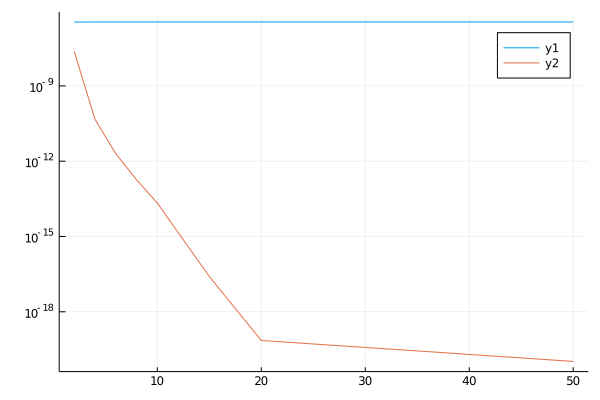

In [50]:
plot(ntab,[errtab_max_L2_Nh,errtab_L2_H10_Nh], yaxis=:log )

In [52]:
import Pkg; 
Pkg.add("GLM")
Pkg.add("DataFrames")
using GLM,DataFrames

  Resolving package versions...
   Updating `C:\Users\sfber\.julia\environments\v1.4\Project.toml`
 [no changes]
   Updating `C:\Users\sfber\.julia\environments\v1.4\Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `C:\Users\sfber\.julia\environments\v1.4\Project.toml`
 [no changes]
   Updating `C:\Users\sfber\.julia\environments\v1.4\Manifest.toml`
 [no changes]


In [53]:
x=log.(ntab)
# print(x)
y= -log.(errtab_max_L2_Nh)
# print(y)
dataregression = DataFrame(x = x,y = y);
lm(@formula(y ~ x),dataregression)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

y ~ 1 + x

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────
                 Estimate   Std. Error      t value  Pr(>|t|)     Lower 95%    Upper 95%
────────────────────────────────────────────────────────────────────────────────────────
(Intercept)  14.8605       0.000486438  30549.7        <1e-25  14.8593       14.8617
x            -0.000396536  0.000201009     -1.97273    0.0960  -0.000888387   9.53145e-5
────────────────────────────────────────────────────────────────────────────────────────

In [54]:
x=log.(ntab)
# print(x)
y= -log.(errtab_L2_H10_Nh)
# print(y)
dataregression = DataFrame(x = x,y = y);
lm(@formula(y ~ x),dataregression)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

y ~ 1 + x

Coefficients:
───────────────────────────────────────────────────────────────────────────
             Estimate  Std. Error   t value  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────────
(Intercept)   10.4395     2.16034   4.83235    0.0029    5.15336    15.7257
x              9.7294     0.89271  10.8987     <1e-4     7.54502    11.9138
───────────────────────────────────────────────────────────────────────────

On fixe "n=10" pour comparer les erreurs ci-dessous:
$$
\begin{array}{cc}
      & POD \\
L^2(0,1)& \approx 10^{-6.5}  \\
H_{0}^{1}(0,1) & \approx 10^{-13.5}
\end{array}
$$
On compare les vitesses ci-dessous:
$$
\begin{array}{cc}
      & POD \\
L^2(0,1)& - \\
H_{0}^{1}(0,1))&O(h^{9.7294})\\
\end{array}
$$

C'est un peu bizzare parce que cette fois-ci l'erreur dans $L^2(0,1)$ est plus grand que l'erreur dans $H_{0}^{1}(0,1))$.
Il faut remarquer que si on augement $n$, l'erreur dans $H_{0}^{1}(0,1))$ peut diminuer encore ayant une vitesse aussi grand que le cas où $c=1$, mais l'erreur dans $L^2(0,1)$ ne peut pas.